In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import plotly.express as px
import plotly.graph_objects as go

In [3]:
def combine_csv_files(folder_path):
    # Get a list of all CSV files in the specified folder
    file_list = [f"{folder_path}/{file}" for file in os.listdir(folder_path) if file.endswith(".csv")]

    # Initialize an empty DataFrame
    combined_df = pd.DataFrame()

    # Loop through the list of CSV files and concatenate them
    for file in file_list:
        # Read each CSV file into a DataFrame
        df = pd.read_csv(file)
        parts = file.split("_")
        df['dataset'] = parts[0]
        df['model'] = parts[1]
        df['seed'] = parts[2]

        # Concatenate the current DataFrame with the combined DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df

In [4]:
folder_path = "../../output/Seed/Result"
seed_df = combine_csv_files(folder_path)

In [5]:
import re

def check_terms_in_list(input_string, elements_list, correct=True):
    # Use regular expression to find terms within square brackets
    terms_in_brackets = re.findall(r'\[([^]]+)\]', input_string)

    terms_lower = [term.lower().strip() for term in terms_in_brackets]
    elements_lower = [element.lower().strip() for element in elements_list]
    # Check if all terms are in the given list
    if correct:
        correct_terms = [term for term in terms_lower if term in elements_lower]
        return correct_terms
    else:
        incorrect_terms = [term for term in terms_lower if term not in elements_lower]
        return incorrect_terms

mesh_term_list = ["Affiliation","ad","All Fields","all","Article Identifier","aid","Author","au","Author Identifier","auid","Book","book","Comment Correction Type","Completion Date","dcom","Conflict of Interest Statement","cois","Corporate Author","cn","Create Date","crdt","EC/RN Number","rn","Editor","ed","Entry Date","edat","Filter","filter","sb","First Author Name","1au","Full Author Name","fau","Full Investigator Name","fir","Grants and Funding","gr","Investigator","ir","ISBN","isbn","Issue","ip","Journal","ta","Language","la","Last Author Name","lastau","Location ID","lid","MeSH Date","mhda","MeSH Major Topic","majr","MeSH Subheadings","sh","MeSH Terms",'MeSH',"mh","Modification Date","lr","NLM Unique ID","jid","Other Term","ot","Owner","Pagination","pg","Personal Name as Subject","ps","Pharmacological Action","pa","Place of Publication","pl","PMCID and MID","PMID","pmid","Publication Date","dp","Publication Type","pt","Publisher","pubn","Secondary Source ID","si","Subset","sb","Supplementary Concept","nm","Text Words","text word","tw","Title","ti","Title/Abstract","tiab","Transliterated Title","tt","Volume","vi", "pdat", "text", "subheading", 'mesh:noexp']

In [36]:
def extract_terms(input, length=False):
    if input.lower().count('error') > 0:
        return pd.NA
    if input.lower().count("i'm sorry") > 0:
        return pd.NA
    if input.lower().count("explanation") > 0:
        return pd.NA
    if input.lower().count('this boolean query') > 0:
        return pd.NA
        
    excluded_words = {'and', 'or', 'not'}
    
    # Case-insensitive regex pattern to find words
    pattern = re.compile(r'\b(?!' + '|'.join(excluded_words) + r'\b)\w+', re.IGNORECASE)
    
    # Find all matches in the input string
    terms = pattern.findall(input)
    if length:
        return len(terms)
    return terms

# Example usage

In [37]:
def parentheses_correct(s):
    if s.lower().count('error') > 0:
        return pd.NA
    if s.lower().count("i'm sorry") > 0:
        return pd.NA
    if s.lower().count("explanation") > 0:
        return pd.NA
        
    stack = []
    opening_brackets = "([{"
    closing_brackets = ")]}"
    
    for char in s:
        if char in opening_brackets:
            stack.append(char)
        elif char in closing_brackets:
            if not stack or opening_brackets.index(stack.pop()) != closing_brackets.index(char):
                return False
    return not stack

In [38]:
fields = questions = ['q1_answer','q2_answer','q3_answer','q4_answer', 'q5_answer','edited_search','query', 'guided_query_answer', 'related_q4_answer', 'related_q5_answer']
#fields = questions = ['q1_answer','q2_answer','q3_answer','q4_answer', 'q5_answer']

for field in fields:
    seed_df[f'{field}_error'] = seed_df[field].apply(lambda x: str(x).lower().count('error')) > 0
    seed_df[f'{field}_not_generated'] = seed_df[field].apply(lambda x: str(x).lower().count("i'm sorry")) > 0
    seed_df[f'{field}_explanation'] = seed_df[field].apply(lambda x: str(x).lower().count('explanation') + str(x).lower().count('note') + str(x).lower().count(' query ')) > 0

for field in fields:
    # Count occurrences of "AND" and "OR" with leading and trailing whitespace
    seed_df[f'{field}_and'] = seed_df[field].apply(lambda x: str(x).lower().count(' and '))
    seed_df[f'{field}_or'] = seed_df[field].apply(lambda x: str(x).lower().count(r' or '))
    seed_df[f'{field}_parentheses_correct'] = seed_df[field].apply(lambda x: parentheses_correct(str(x)))
    seed_df[f'{field}_operators'] = seed_df[f'{field}_and'] + seed_df[f'{field}_or'] 
    seed_df[f'{field}_mesh_terms_correct'] = seed_df[field].apply(lambda x: check_terms_in_list(str(x), mesh_term_list))
    seed_df[f'{field}_mesh_terms_incorrect'] = seed_df[field].apply(lambda x: check_terms_in_list(str(x), mesh_term_list, correct=False))
    seed_df[f'{field}_term'] = seed_df[field].apply(lambda x: extract_terms(str(x)))
    seed_df[f'{field}_term_len'] = seed_df[field].apply(lambda x: extract_terms(str(x), True))

In [39]:
seed_df[['q3_answer','q3_answer_error', 'q3_answer_parentheses_correct']]

,q3_answer,q3_answer_error,q3_answer_parentheses_correct
0,"(""differentiated thyroid cancer"" OR ""thyroid n...",False,True
1,"(""differentiated thyroid cancer"" OR ""thyroid n...",False,True
2,Error: Unexpected exception (ReadTimeout): The...,True,<NA>
3,Error: Unexpected exception (ReadTimeout): The...,True,<NA>
4,"(""surgeon's effect"" OR ""surgical impact"" OR ""p...",False,True
...,...,...,...
1755,"((""intensive care units"" [Title/Abstract] OR I...",False,False
1756,"(""End of Life Care"" OR ""Palliative Care"" OR ""H...",False,False
1757,"(""COVID-19"" OR SARS-CoV-2) AND (healthcare OR ...",False,True
1758,"(""face masks"" OR mask OR facial hoods) AND (do...",False,True


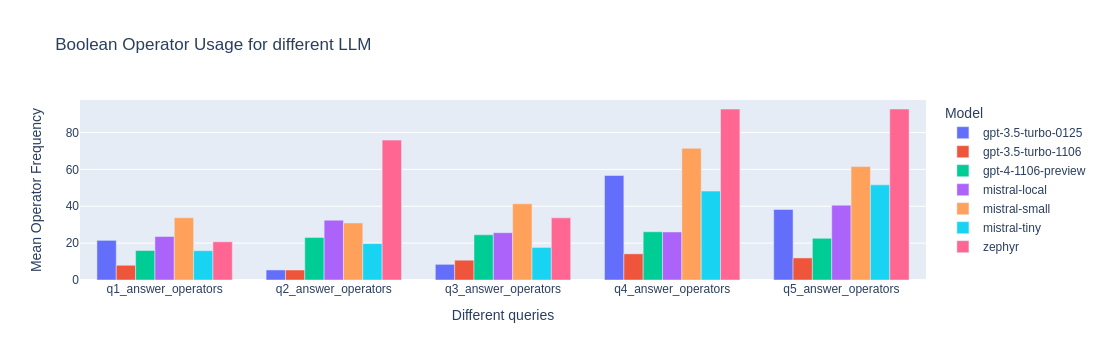

In [40]:
#melted_df = pd.melt(seed_df, id_vars=['model'], value_vars=['q1_answer_operators', 'q2_answer_operators', 'q3_answer_operators', 'q4_answer_operators', 'q5_answer_operators', 'edited_search_operators', 'query_operators', 'guided_query_answer_operators'],
#                    var_name='query', value_name='operator')

melted_df = pd.melt(seed_df, id_vars=['model'], value_vars=['q1_answer_operators', 'q2_answer_operators', 'q3_answer_operators', 'q4_answer_operators', 'q5_answer_operators'],
                    var_name='query', value_name='operator')
# Group by 'model' and sum the answers for each question
summed_df = melted_df.groupby(['model', 'query']).mean().reset_index()

custom_labels = {'q1_answer_operators': 'q1', 'q2_answer_operators': 'q2', 'q3_answer_operators': 'q3', 'q4_answer_operators': 'q4', 'q5_answer_operators': 'q5', 'edited_search_operators': 'Edited Search', 'query_operators': 'query', 'guided_query_operators': 'guided query'}


fig = px.bar(summed_df, x='query', y='operator', color='model',
             title='Boolean Operator Usage for different LLM',
             labels={'query': 'Different queries', 'operator': 'Mean Operator Frequency', 'model': 'Model'},
             category_orders={'question': custom_labels})

# Customize layout if needed
fig.update_layout(barmode='group', xaxis={'type': 'category'})

# Show the plot
fig.show()

In [41]:
error_columns = [col for col in seed_df.columns if  col.endswith("_parentheses_correct")]

filtered_df = seed_df[(seed_df[error_columns] == False).any(axis=1)]

true_counts = seed_df[error_columns].sum(axis=1)


print(sum(true_counts))

14958


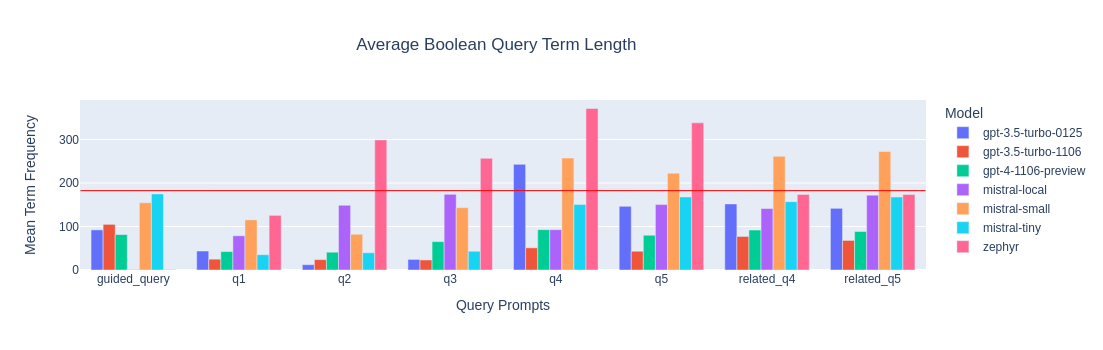

In [52]:
melted_df = pd.melt(seed_df, id_vars=['model'], value_vars=['q1_answer_term_len', 'q2_answer_term_len', 'q3_answer_term_len', 'q4_answer_term_len', 'q5_answer_term_len', 'guided_query_answer_term_len', 'related_q4_answer_term_len', 'related_q5_answer_term_len'],
                    var_name='query', value_name='operator')
#melted_df = pd.melt(seed_df, id_vars=['model'], value_vars=['q1_answer_term_len', 'q2_answer_term_len', 'q3_answer_term_len', 'q4_answer_term_len', 'q5_answer_term_len'],
#                    var_name='query', value_name='operator')

# Group by 'model' and sum the answers for each question
summed_df = melted_df.groupby(['model', 'query']).mean().reset_index()
summed_df['query'] = summed_df['query'].apply(lambda x: x.rstrip("_answer_term_len"))

#custom_labels = {'q1_answer_term_len': 'q1', 'q2_answer_term_len': 'q2', 'q3_answer_term_len': 'q3', 'q4_answer_term_len': 'q4', 'q5_answer_term_len': 'q5', 'guided_query_term_len': 'guided query'}
#custom_labels = ['q1','q2','q3','q4','q5','guided_query']

fig = px.bar(summed_df, x='query', y='operator', color='model',
             title='Average Boolean Query Term Length',
             labels={'query': 'Query Prompts', 'operator': 'Mean Term Frequency', 'model': 'Model'},
     )

fig.add_shape(type="line",
    x0=-0.5, y0=182.5, x1=7.5, y1=182.5,
    line=dict(color="Red",width=1)
)



# Customize layout if needed
fig.update_layout(barmode='group', xaxis={'type': 'category'},legend=dict(font=dict(size=12))
, width=700, height=350, title_x=0.45)


# Show the plot
fig.show()
fig.write_image("average_term_length.pdf")

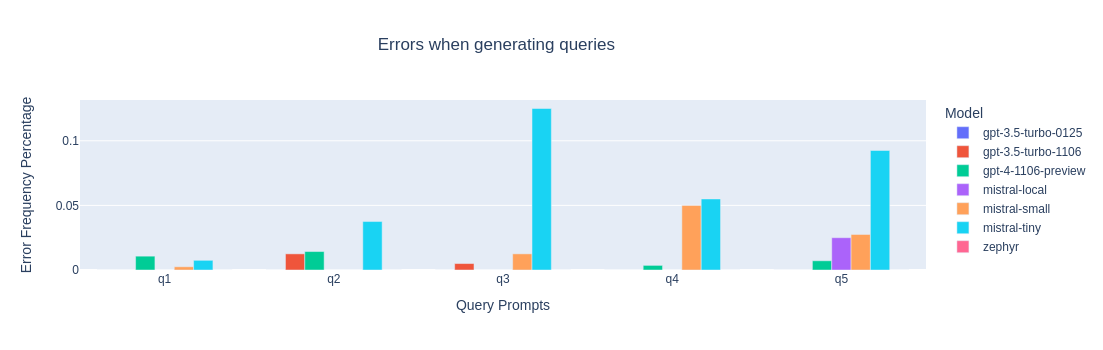

In [60]:
melted_df = pd.melt(seed_df, id_vars=['model'], value_vars=['q1_answer_error', 'q2_answer_error', 'q3_answer_error', 'q4_answer_error', 'q5_answer_error'],
                    var_name='query', value_name='operator')

# Group by 'model' and sum the answers for each question
summed_df = melted_df.groupby(['model', 'query']).sum().reset_index()
summed_df['count'] = melted_df.groupby(['model', 'query']).count().reset_index()['operator']
summed_df['operator']  = summed_df['operator']/summed_df['count']



summed_df['query'] = summed_df['query'].apply(lambda x: x.rstrip("_answer_error"))
#custom_labels = {'q1_answer_error': 'q1', 'q2_answer_error': 'q2', 'q3_answer_error': 'q3', 'q4_answer_error': 'q4', 'q5_answer_error': 'q5', 'guided_query_error': 'guided query'}
#custom_labels = ['q1','q2','q3','q4','q5','guided_query']

fig = px.bar(summed_df, x='query', y='operator', color='model',
             title='Errors when generating queries',
             labels={'query': 'Query Prompts', 'operator': 'Error Frequency Percentage', 'model': 'Model'},
     )

# Customize layout if needed
fig.update_layout(barmode='group', xaxis={'type': 'category'}, width=700, height=350, title_x=0.45)

# Show the plot
fig.show()
fig.write_image("error_generating.pdf")

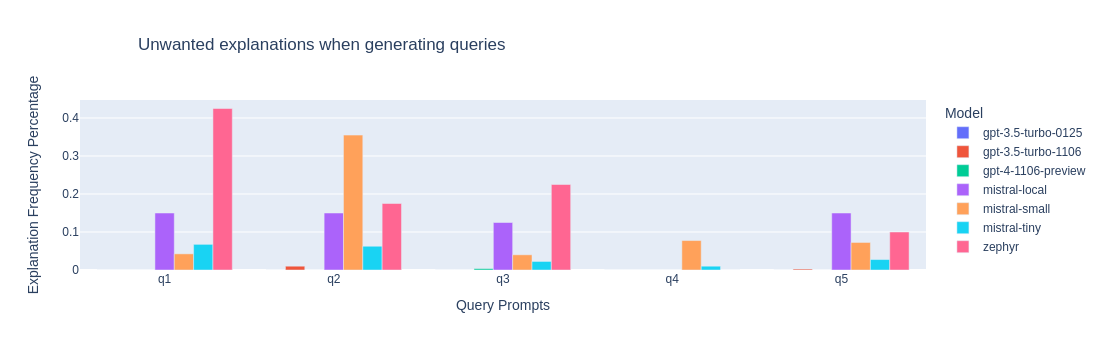

In [54]:
melted_df = pd.melt(seed_df, id_vars=['model'], value_vars=['q1_answer_explanation', 'q2_answer_explanation', 'q3_answer_explanation', 'q4_answer_explanation', 'q5_answer_explanation'],
                    var_name='query', value_name='operator')

# Group by 'model' and sum the answers for each question
summed_df = melted_df.groupby(['model', 'query']).sum().reset_index()
summed_df['count'] = melted_df.groupby(['model', 'query']).count().reset_index()['operator']
summed_df['operator']  = summed_df['operator']/summed_df['count']



summed_df['query'] = summed_df['query'].apply(lambda x: x.rstrip("_answer_explanation"))
#custom_labels = {'q1_answer_explanation': 'q1', 'q2_answer_explanation': 'q2', 'q3_answer_explanation': 'q3', 'q4_answer_explanation': 'q4', 'q5_answer_explanation': 'q5', 'guided_query_explanation': 'guided query'}
#custom_labels = ['q1','q2','q3','q4','q5','guided_query']

fig = px.bar(summed_df, x='query', y='operator', color='model',
             title='Unwanted explanations when generating queries',
             labels={'query': 'Query Prompts', 'operator': 'Explanation Frequency Percentage', 'model': 'Model'},
     )

# Customize layout if needed
fig.update_layout(barmode='group', xaxis={'type': 'category'}, width=700, height=350, title_x=0.125)

# Show the plot
fig.show()

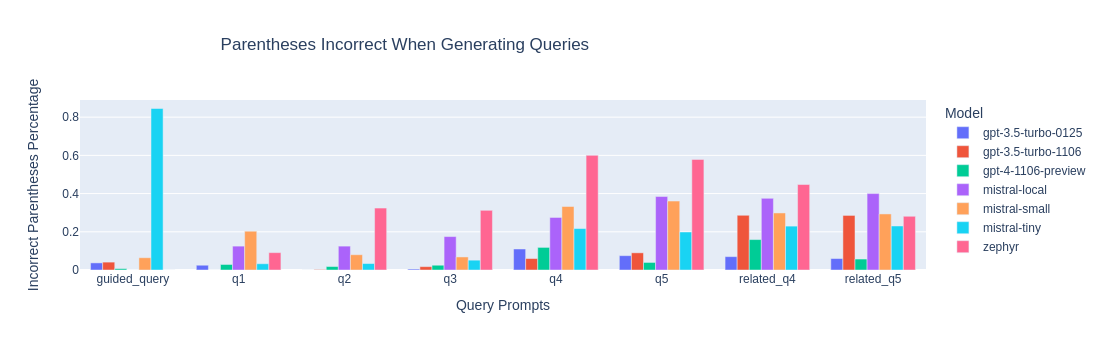

In [64]:
melted_df = pd.melt(seed_df, id_vars=['model'], value_vars=['q1_answer_parentheses_correct', 'q2_answer_parentheses_correct', 'q3_answer_parentheses_correct', 'q4_answer_parentheses_correct', 'q5_answer_parentheses_correct', 'guided_query_answer_parentheses_correct', 'related_q4_answer_parentheses_correct', 'related_q5_answer_parentheses_correct'],
                    var_name='query', value_name='operator')

# Group by 'model' and sum the answers for each question
summed_df = melted_df.groupby(['model', 'query']).sum().reset_index()
summed_df['count'] = melted_df.groupby(['model', 'query']).count().reset_index()['operator']
summed_df['operator']  = 1 - summed_df['operator']/summed_df['count']



summed_df['query'] = summed_df['query'].apply(lambda x: x.rstrip("_answer_parentheses_correct"))
#custom_labels = {'q1_answer_parentheses_correct': 'q1', 'q2_answer_parentheses_correct': 'q2', 'q3_answer_parentheses_correct': 'q3', 'q4_answer_parentheses_correct': 'q4', 'q5_answer_parentheses_correct': 'q5', 'guided_query_parentheses_correct': 'guided query'}
#custom_labels = ['q1','q2','q3','q4','q5','guided_query']

fig = px.bar(summed_df, x='query', y='operator', color='model',
             title='Parentheses Incorrect When Generating Queries',
             labels={'query': 'Query Prompts', 'operator': 'Incorrect Parentheses Percentage', 'model': 'Model'},
     )

# Customize layout if needed
fig.update_layout(barmode='group', xaxis={'type': 'category'}, width=700, height=350, title_x=0.20)

# Show the plot
fig.show()
fig.write_image("parentheses_incorrect.pdf")

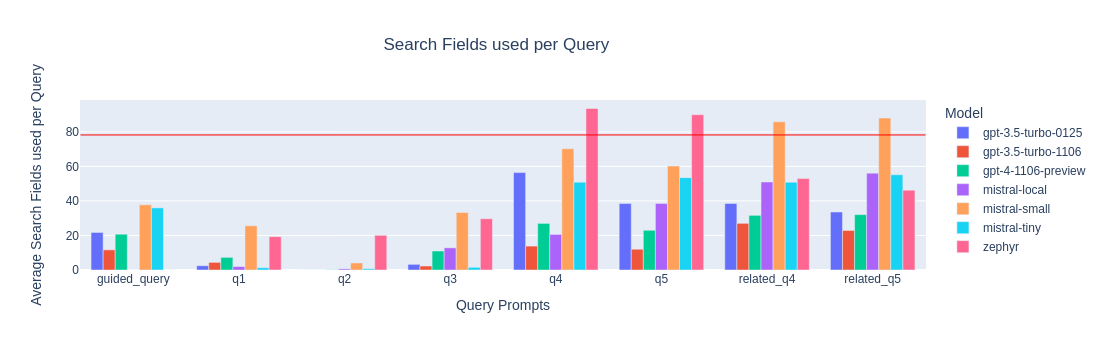

In [63]:
melted_df = pd.melt(seed_df, id_vars=['model'], value_vars=['q1_answer_mesh_terms_correct', 'q2_answer_mesh_terms_correct', 'q3_answer_mesh_terms_correct', 'q4_answer_mesh_terms_correct', 'q5_answer_mesh_terms_correct', 'guided_query_answer_mesh_terms_correct', 'related_q4_answer_mesh_terms_correct', 'related_q5_answer_mesh_terms_correct'],
                    var_name='query', value_name='operator')

melted_df['operator'] = melted_df['operator'].apply(lambda x: len(x))
# Group by 'model' and sum the answers for each question
summed_df = melted_df.groupby(['model', 'query']).mean().reset_index()


summed_df['query'] = summed_df['query'].apply(lambda x: x.rstrip("_answer_mesh_terms_correct"))
#custom_labels = {'q1_answer_mesh_terms_correct': 'q1', 'q2_answer_mesh_terms_correct': 'q2', 'q3_answer_mesh_terms_correct': 'q3', 'q4_answer_mesh_terms_correct': 'q4', 'q5_answer_mesh_terms_correct': 'q5', 'guided_query_mesh_terms_correct': 'guided query'}
#custom_labels = ['q1','q2','q3','q4','q5','guided_query']

fig = px.bar(summed_df, x='query', y='operator', color='model',
             title='Search Fields used per Query',
             labels={'query': 'Query Prompts', 'operator': 'Average Search Fields used per Query', 'model': 'Model'},
     )

fig.add_shape(type="line",
    x0=-0.5, y0=78.2, x1=7.5, y1=78.2,
    line=dict(color="Red",width=1)
)

# Customize layout if needed
fig.update_layout(barmode='group', xaxis={'type': 'category'}, width=700, height=350, title_x=0.45)

# Show the plot
fig.show()
fig.write_image("average_search_fields.pdf")

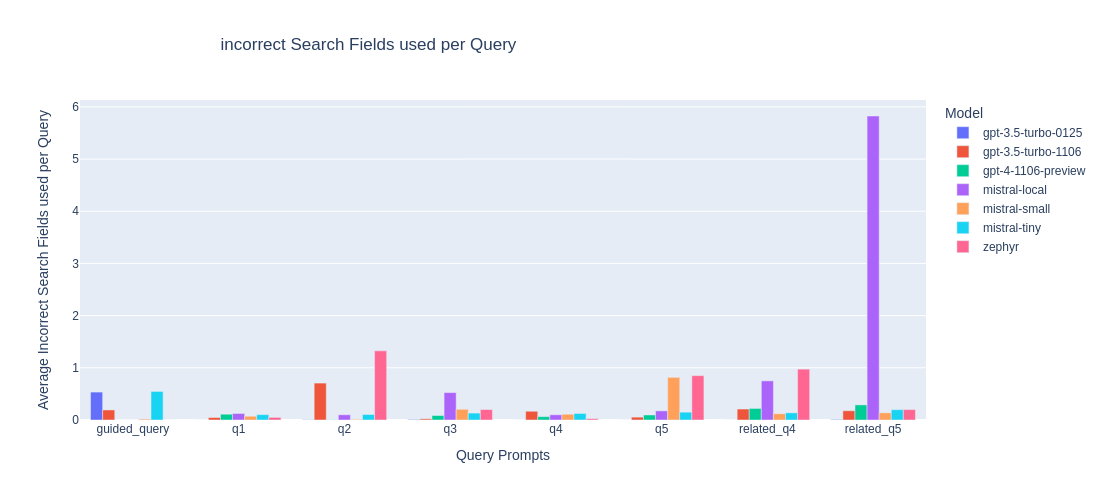

In [47]:
melted_df = pd.melt(seed_df, id_vars=['model'], value_vars=['q1_answer_mesh_terms_incorrect', 'q2_answer_mesh_terms_incorrect', 'q3_answer_mesh_terms_incorrect', 'q4_answer_mesh_terms_incorrect', 'q5_answer_mesh_terms_incorrect', 'guided_query_answer_mesh_terms_incorrect', 'related_q4_answer_mesh_terms_incorrect', 'related_q5_answer_mesh_terms_incorrect'],
                    var_name='query', value_name='operator')


#test = melted_df[melted_df['model']=='gpt-3.5-turbo-1106']
#print(test[test['query']=='q2_answer_mesh_terms_incorrect']['operator'].values.tolist())

melted_df['operator'] = melted_df['operator'].apply(lambda x: len(x))

# Group by 'model' and sum the answers for each question
summed_df = melted_df.groupby(['model', 'query']).mean().reset_index()


summed_df['query'] = summed_df['query'].apply(lambda x: x.rstrip("_answer_mesh_terms_incorrect"))
#custom_labels = {'q1_answer_mesh_terms_incorrect': 'q1', 'q2_answer_mesh_terms_incorrect': 'q2', 'q3_answer_mesh_terms_incorrect': 'q3', 'q4_answer_mesh_terms_incorrect': 'q4', 'q5_answer_mesh_terms_incorrect': 'q5', 'guided_query_mesh_terms_incorrect': 'guided query'}
#custom_labels = ['q1','q2','q3','q4','q5','guided_query']

fig = px.bar(summed_df, x='query', y='operator', color='model',
             title='incorrect Search Fields used per Query',
             labels={'query': 'Query Prompts', 'operator': 'Average Incorrect Search Fields used per Query', 'model': 'Model'},
     )

# Customize layout if needed
fig.update_layout(barmode='group', xaxis={'type': 'category'}, width=600, height=500, title_x=0.2)

# Show the plot
fig.show()

In [ ]:
from collections import Counter
melted_df = pd.melt(seed_df, id_vars=['model'], value_vars=['q1_answer_mesh_terms_correct', 'q2_answer_mesh_terms_correct', 'q3_answer_mesh_terms_correct', 'q4_answer_mesh_terms_correct', 'q5_answer_mesh_terms_correct', 'guided_query_answer_mesh_terms_correct', 'related_q4_answer_mesh_terms_correct', 'related_q5_answer_mesh_terms_correct', 'query_mesh_terms_correct', 'edited_search_mesh_terms_correct'],
                    var_name='query', value_name='operator')

melted_df.loc[melted_df['query'] == 'edited_search_mesh_terms_correct', 'model'] = "edited-search"
# Step 1: Flatten the lists of terms
flattened_terms = [term for sublist in melted_df['operator'] for term in sublist]

# Step 2: Group the DataFrame by the 'model' column
grouped = melted_df.groupby('model')

most_frequent_terms = []
for model, group_df in grouped:
    terms = [term for sublist in group_df['operator'] for term in sublist]
    term_frequency = Counter(terms)
    most_common_terms = term_frequency.most_common(5)  # Select the top 3 most frequent terms
    most_frequent_terms.extend([{'model': model, 'term': term, 'frequency': freq} for term, freq in most_common_terms])

# Step 5: Create a new DataFrame to store the most frequent terms and their frequencies for each model
most_frequent_df = pd.DataFrame(most_frequent_terms) 
rename_dict = {'tiab': 'title/abstract', 'ti': 'title', 'mesh': 'mesh terms', 'pt': 'publication type', 'sh': 'mesh subheadings'}

# Use map() function to rename terms based on the dictionary
most_frequent_df['term'] = most_frequent_df['term'].map(lambda x: rename_dict.get(x, x))

melted_df = melted_df.groupby(['model']).count().reset_index()
most_frequent_df = most_frequent_df.merge(melted_df, how="inner")
most_frequent_df = most_frequent_df.groupby(['model','term']).sum().reset_index()
most_frequent_df['frequency'] = most_frequent_df['frequency'] / most_frequent_df['operator']
# Plot
fig = px.bar(most_frequent_df, x='model', y='frequency', color='term', title='Most common Search Fields',
             labels={'model': 'Model', 'frequency': 'Frequency per Query', 'term': 'Term'},
             barmode='group')


fig.update_layout(width=600, height=500, title_x = 0.45)  # Sort x-axis categories by total frequency
fig.show()

In [73]:
def combine_csv_files(folder_path):
    # Initialize an empty DataFrame
    combined_df = pd.DataFrame()

    subdirectories = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Loop through each subdirectory
    for subdir in subdirectories:
        # List all CSV files in the subdirectory
        csv_files = [f.path for f in os.scandir(subdir) if f.is_file() and f.name.endswith('.csv')]
        
        # Loop through each CSV file
        for csv_file in csv_files:
            # Read CSV file into a DataFrame and append it to the list
            df = pd.read_csv(csv_file)
            parts = df.apply(lambda x: .split('_')
            if parts[len(parts)-2] =='related':
                df['query'] = parts[len(parts)-2]+"_"+parts[len(parts)-1]
            else:
                df['query'] = parts[len(parts)-1]
            df['model']=parts[1]
            dfs.append(df)
    
    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df

folder_path = "../../data/3-evaluated/seed"
seed_df = combine_csv_files(folder_path)

NameError: name 'filename' is not defined

In [69]:
seed_df

,query_id,precision,recall,f1,f3,f05,run_name
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5
2,3,0.004267,0.750000,0.008487,0.040595,0.005327,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5
4,6,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5
...,...,...,...,...,...,...,...
17256,102,0.125000,0.090909,0.105263,0.093458,0.116279,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...
17257,103,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...
17258,105,0.007642,0.875000,0.015152,0.070850,0.009532,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...
17259,112,0.006191,0.633333,0.012262,0.056903,0.007720,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...


In [96]:
df_split = seed_df['run_name'].str.split('_', expand=True)
df_split

,0,1,2,3,4,5,6
0,Seed,gpt-3.5-turbo-0125,4187709,meta,related,q5,None
1,Seed,gpt-3.5-turbo-0125,4187709,meta,related,q5,None
2,Seed,gpt-3.5-turbo-0125,4187709,meta,related,q5,None
3,Seed,gpt-3.5-turbo-0125,4187709,meta,related,q5,None
4,Seed,gpt-3.5-turbo-0125,4187709,meta,related,q5,None
...,...,...,...,...,...,...,...
17256,Seed,gpt-3.5-turbo-1106,2426957,meta,edited-search,None,None
17257,Seed,gpt-3.5-turbo-1106,2426957,meta,edited-search,None,None
17258,Seed,gpt-3.5-turbo-1106,2426957,meta,edited-search,None,None
17259,Seed,gpt-3.5-turbo-1106,2426957,meta,edited-search,None,None


In [110]:
df_new = seed_df.copy()

# Iterate through split_df
for index, row in split_df.iterrows():
    if row[4] == "related":
        query_value = row[4] + "_" + row[5]
    else:
        query_value = row[4]
    df_new.at[index, 'query'] = query_value

df_new

,query_id,precision,recall,f1,f3,f05,run_name,query
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5,related_q5
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5,related_q5
2,3,0.004267,0.750000,0.008487,0.040595,0.005327,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5,related_q5
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5,related_q5
4,6,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5,related_q5
...,...,...,...,...,...,...,...,...
17256,102,0.125000,0.090909,0.105263,0.093458,0.116279,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...,edited-search
17257,103,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...,edited-search
17258,105,0.007642,0.875000,0.015152,0.070850,0.009532,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...,edited-search
17259,112,0.006191,0.633333,0.012262,0.056903,0.007720,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...,edited-search


In [112]:
# Iterate through split_df
for index, row in split_df.iterrows():
    query_value = row[1]
    df_new.at[index, 'model'] = query_value

df_new

,query_id,precision,recall,f1,f3,f05,run_name,query,model
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5,related_q5,gpt-3.5-turbo-0125
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5,related_q5,gpt-3.5-turbo-0125
2,3,0.004267,0.750000,0.008487,0.040595,0.005327,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5,related_q5,gpt-3.5-turbo-0125
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5,related_q5,gpt-3.5-turbo-0125
4,6,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-0125_4187709_meta_related_q5,related_q5,gpt-3.5-turbo-0125
...,...,...,...,...,...,...,...,...,...
17256,102,0.125000,0.090909,0.105263,0.093458,0.116279,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...,edited-search,gpt-3.5-turbo-1106
17257,103,0.000000,0.000000,0.000000,0.000000,0.000000,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...,edited-search,gpt-3.5-turbo-1106
17258,105,0.007642,0.875000,0.015152,0.070850,0.009532,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...,edited-search,gpt-3.5-turbo-1106
17259,112,0.006191,0.633333,0.012262,0.056903,0.007720,Seed_gpt-3.5-turbo-1106_2426957_meta_edited-se...,edited-search,gpt-3.5-turbo-1106


In [127]:
filtered_df = df_new[df_new['query'].isin(['q4', 'q5'])]
filtered_df = filtered_df.sort_values(by=['model'])

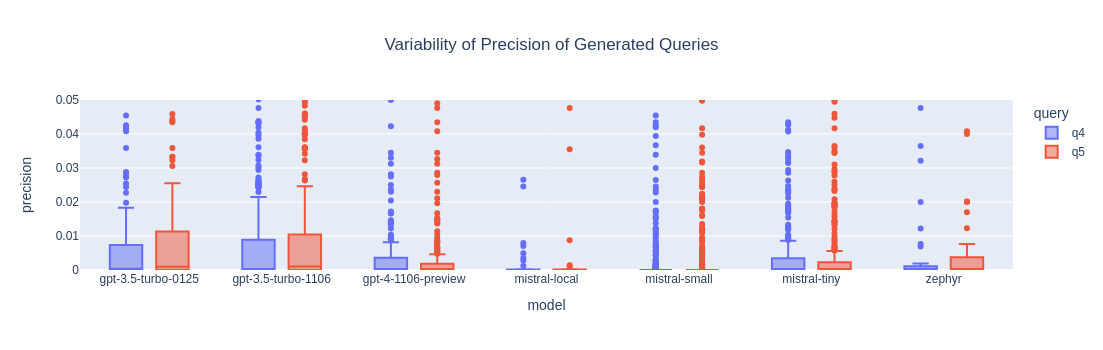

In [142]:
fig = px.box(filtered_df, x='model', y='precision', color='query', title='Variability of Precision of Generated Queries')
fig.update_yaxes(range=[0, 0.05])
# Show the plot
# Customize layout if needed
fig.update_layout(width=700, height=350, title_x=0.50)

# Show the plot
fig.show()
fig.write_image("precision_plot.pdf")